In [1]:
import torch
import torch.nn as nn
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print(torch.version.cuda)

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from datasets import Dataset

from transformers import AutoTokenizer, AutoModelForCausalLM

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Torch version: 2.4.0+cu121
Torchvision version: 0.19.0+cu121
12.1


2024-11-29 21:17:01.301800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 21:17:01.301839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 21:17:01.302567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 21:17:01.306205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 21:17:01.853557: W tensorflow/compiler/tf2

## 获得模型和tokenizer

In [2]:
base_model="yuntaozh/custom_llama"
max_seq_length=5020

model = AutoModelForCausalLM.from_pretrained(base_model, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# 不加这两句话 trainer.train()可能报错
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

print(model)

Replacing:  Linear <class 'transformers_modules.yuntaozh.custom_llama.ab192f6037e0cb576942f0e6ff9ed9071dddb3ef.modeling_custom_llama.MyLinear'>
Replacing:  Linear <class 'transformers_modules.yuntaozh.custom_llama.ab192f6037e0cb576942f0e6ff9ed9071dddb3ef.modeling_custom_llama.MyLinear'>
Replacing:  Linear <class 'transformers_modules.yuntaozh.custom_llama.ab192f6037e0cb576942f0e6ff9ed9071dddb3ef.modeling_custom_llama.MyLinear'>
Replacing:  Linear <class 'transformers_modules.yuntaozh.custom_llama.ab192f6037e0cb576942f0e6ff9ed9071dddb3ef.modeling_custom_llama.MyLinear'>
Replacing:  Linear <class 'transformers_modules.yuntaozh.custom_llama.ab192f6037e0cb576942f0e6ff9ed9071dddb3ef.modeling_custom_llama.MyLinear'>
Replacing:  Linear <class 'transformers_modules.yuntaozh.custom_llama.ab192f6037e0cb576942f0e6ff9ed9071dddb3ef.modeling_custom_llama.MyLinear'>
Replacing:  Linear <class 'transformers_modules.yuntaozh.custom_llama.ab192f6037e0cb576942f0e6ff9ed9071dddb3ef.modeling_custom_llama.MyL

## 处理arc_challenge数据集，构造提示词

In [3]:
from datasets import load_dataset

arc = load_dataset("allenai/ai2_arc", "ARC-Challenge")

In [4]:
for i in range(len(arc['train'])):
    if len(arc['train'][i]['choices']['text'])!=4:
        print(i)

indices_to_remove = {461, 626}

# 过滤掉选项不是四个的数据
arc = arc['train'].filter(lambda _, idx: idx not in indices_to_remove, with_indices=True)

461
626


In [5]:
prompt_template="""{}
Answer: {}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompt(examples):
    questions = [q.strip() for q in examples['question']]
    choices = [example['text'] for example in examples['choices']]
    answerKeys = examples['answerKey']
    labels = [example['label'] for example in examples['choices']]
    
    texts = []
    
    for question, choice, answerKey, label in zip(questions, choices, answerKeys, labels):
        answer_idx=label.index(answerKey)
        text = prompt_template.format(question, choice[answer_idx]) + EOS_TOKEN # 注意最后要加上EOS
        texts.append(text)
    return { "text" : texts, }

In [6]:
training_data=arc.map(formatting_prompt, batched= True)

In [7]:
print(training_data[0]['text'])

George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
Answer: dry palms<|end_of_text|>


In [8]:
# 计算所有text的长度
training_data = training_data.map(lambda x: {"text_len": len(x["text"])})
print(training_data[0]['text_len'])
print(len(training_data))

135
1117


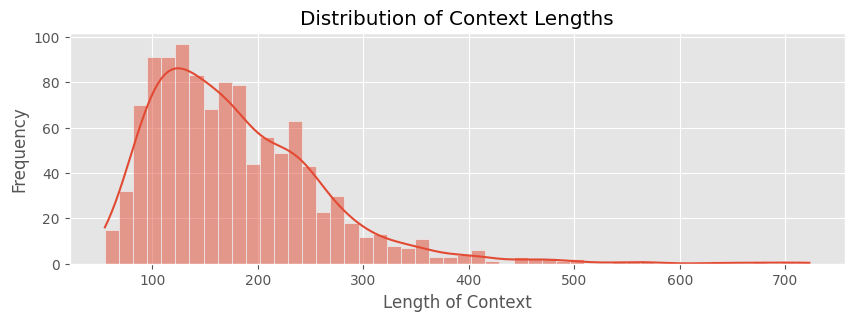

In [9]:
plt.figure(figsize=(10, 3))
sns.histplot(training_data['text_len'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

## Our method 微调

In [10]:
from peft import IA3Config, get_peft_model,TaskType

In [11]:
# 增加o_proj
peft_config = IA3Config(
    task_type=TaskType.SEQ_CLS, target_modules=["k_proj", "v_proj", "down_proj", "o_proj"], feedforward_modules=["down_proj"]
)

In [12]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 172,048 || all params: 1,236,027,440 || trainable%: 0.0139


In [13]:
from trl import SFTConfig, SFTTrainer

In [14]:
# 在arc_challenge上微调50个epochs
# 因为引入了RMSNorm，不同于LoRA和IA3，这会导致微调开始时和原模型的输出不同，所以需要更多的epochs才可能达到相同效果
training_args = SFTConfig(
    max_seq_length=max_seq_length,
    learning_rate=3e-4,
    lr_scheduler_type="linear",
    per_device_train_batch_size=3,
    gradient_accumulation_steps=16,
    num_train_epochs=50,
    fp16=True,
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    warmup_steps=10,
    output_dir="output",
    seed=0,
)

In [15]:
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_num_proc=2,
    args=training_args
)

In [16]:
trainer.train()

Step,Training Loss
1,5.629900
2,5.525800
3,5.660800
4,5.506200
5,5.687800
6,5.723500
7,5.671400
8,5.666000
9,5.563000
10,5.603600


TrainOutput(global_step=1150, training_loss=3.50585660416147, metrics={'train_runtime': 759.3424, 'train_samples_per_second': 73.55, 'train_steps_per_second': 1.514, 'total_flos': 1.5942700165283904e+16, 'train_loss': 3.50585660416147, 'epoch': 49.32975871313673})

In [17]:
save_directory="model/1B_finetuned_llama3.2_ours_arc_challenge"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('model/1B_finetuned_llama3.2_ours_arc_challenge/tokenizer_config.json',
 'model/1B_finetuned_llama3.2_ours_arc_challenge/special_tokens_map.json',
 'model/1B_finetuned_llama3.2_ours_arc_challenge/tokenizer.json')

In [18]:
# os.environ["HF_TOKEN"] = "换成你自己的hugging face密钥"
model.push_to_hub("1B_finetuned_llama3.2_ours_arc_challenge", use_auth_token=os.getenv("HF_TOKEN"))
tokenizer.push_to_hub("1B_finetuned_llama3.2_ours_arc_challenge", use_auth_token=os.getenv("HF_TOKEN"))

adapter_model.safetensors:   0%|          | 0.00/696k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/yuntaozh/1B_finetuned_llama3.2_ours_arc_challenge/commit/ee5fc66b9c08e80cb6273ce4fc0e944f68852f12', commit_message='Upload tokenizer', commit_description='', oid='ee5fc66b9c08e80cb6273ce4fc0e944f68852f12', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yuntaozh/1B_finetuned_llama3.2_ours_arc_challenge', endpoint='https://huggingface.co', repo_type='model', repo_id='yuntaozh/1B_finetuned_llama3.2_ours_arc_challenge'), pr_revision=None, pr_num=None)